In [1]:
import numpy as np
import pandas as pd
import os
import sys
import shutil
import glob
from collections import Counter
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.optim import *
import matplotlib.pyplot as plt
import torch.nn.functional as F
!pip install torchstat -i http://pypi.douban.com/simple/ --trusted-host pypi.douban.com
from torchstat import stat
import math

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Looking in indexes: http://pypi.douban.com/simple/


In [2]:
def download_dataset(dataset_name, file_url, dataset_dir):
    '''
        数据集下载
    '''
    # 检查是否存在源数据
    if os.path.exists(dataset_dir):
        return 

    print('\n==================================================【 %s 数据集下载】===================================================\n'%(dataset_name))
    print('url: %s\n'%(file_url))

    dir_path = dataset_dir.split('/')[0]
    if dataset_name == 'UniMiB-SHAR' and file_url[-4:] == '.git': # 由于unimib数据集无法直接访问下载，这里我把unimib数据集上传到github进行访问clone
        if os.path.exists(os.path.join(dir_path, dataset_name)):
            shutil.rmtree(os.path.join(dir_path, dataset_name))
        os.system('git clone %s %s/%s' % (file_url, dir_path, dataset_name))
   
    else: # 其他数据集
        # download
        dataset_file_path = os.path.join(dir_path, 'dataset.zip')
        os.system(f"wget -O {dataset_file_path} {file_url}")

        # unpack
        while glob.glob(os.path.join(dir_path, '*.zip')):
            for file in glob.glob(os.path.join(dir_path, '*.zip')):
                for format in ["zip", "tar", "gztar", "bztar", "xztar"]:
                    try:
                        shutil.unpack_archive(filename=file, extract_dir=dir_path, format=format)
                        break
                    except:
                        continue
                os.remove(file)

    print()

    # 检查数据集是否下载完毕
    if not os.path.exists(dataset_dir):
        quit('数据集下载失败，请检查url与网络后重试')

def save_npy_data(dataset_name, root_dir, xtrain, xtest, ytrain, ytest):
    '''
        dataset_name: 数据集
        root_dir: 数据集保存根目录
        xtrain: 训练数据 : array  [n1, window_size, modal_leng]
        xtest: 测试数据 : array   [n2, window_size, modal_leng]
        ytrain: 训练标签 : array  [n1,]
        ytest: 测试标签 : array   [n2,]
    '''
    path = os.path.join(root_dir, dataset_name)
    if not os.path.exists(path):
        os.makedirs(path)
    np.save(path + '/x_train.npy', xtrain)
    np.save(path + '/x_test.npy', xtest)
    np.save(path + '/y_train.npy', ytrain)
    np.save(path + '/y_test.npy', ytest)
    print('\n.npy数据【xtrain，xtest，ytrain，ytest】已经保存在【%s】目录下\n' % (root_dir))
    build_npydataset_readme(root_dir)
    
def build_npydataset_readme(path):
    '''
        构建数据集readme
    '''
    datasets = sorted(os.listdir(path)) 
    curdir = os.curdir # 记录当前地址
    os.chdir(path) # 进入所有npy数据集根目录
    with open('readme.md', 'w') as w:
        for dataset in datasets:
            if not os.path.isdir(dataset):
                continue
            x_train = np.load('%s/x_train.npy' % (dataset))
            x_test = np.load('%s/x_test.npy' % (dataset))
            y_train = np.load('%s/y_train.npy' % (dataset))
            y_test = np.load('%s/y_test.npy' % (dataset))
            category = len(set(y_test.tolist()))
            d = Counter(y_test)
            new_d = {} # 顺序字典
            for i in range(category):
                new_d[i] = d[i]
            log = '\n===============================================================\n%s\n   x_train shape: %s\n   x_test shape: %s\n   y_train shape: %s\n   y_test shape: %s\n\n共【%d】个类别\ny_test中每个类别的样本数为 %s\n' % (dataset, x_train.shape, x_test.shape, y_train.shape, y_test.shape, category, new_d)
            w.write(log)
    os.chdir(curdir) # 返回原始地址
    
def sliding_window(array, windowsize, overlaprate):
    '''
    array: 二维数据(n, m)，n为时序长度，m为模态轴数。: list or array。
    windowsize: 窗口尺寸
    overlaprate: 重叠率
    '''
    stride = int(windowsize * (1 - overlaprate)) # 计算stride
    times = (len(array)-windowsize)//stride + 1 # 滑窗次数，同时也是滑窗后数据长度
    res = []
    for i in range(times):
        x = array[i*stride : i*stride+windowsize]
        res.append(x)
    return res

In [3]:
os.chdir(sys.path[0])
sys.path.append('../')
def UCI(dataset_dir='./UCI HAR Dataset', SAVE_PATH='./HAR-datasets'):
    '''
        dataset_dir: 源数据目录 : str
        SAVE_PATH: 预处理后npy数据保存目录 : str
    '''
    
    print("\n原数据分析：原数据已经指定比例切分好，窗口大小128，重叠率50%\n")
    print("预处理思路：读取数据，txt转numpy array\n")

    # 下载数据集
    download_dataset(
        dataset_name='UCI-HAR',
        file_url='https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip',
        dataset_dir=dataset_dir
    )
        
    dataset = dataset_dir

    signal_class = [
        'body_acc_x_',
        'body_acc_y_',
        'body_acc_z_',
        'body_gyro_x_',
        'body_gyro_x_',
        'body_gyro_x_',
        'total_acc_x_',
        'total_acc_y_',
        'total_acc_z_',
    ]

    def xload(X_path):
        x = []
        for each in X_path:
            with open(each, 'r') as f:
                x.append(np.array([eachline.replace('  ', ' ').strip().split(' ') for eachline in f], dtype=np.float32))
        x = np.transpose(x, (1, 2, 0))
        return x

    def yload(Y_path):
        y = pd.read_csv(Y_path, header=None).to_numpy().reshape(-1)
        return y - 1  # label从0开始

    X_train_path = [dataset + '/train/Inertial Signals/' + signal + 'train.txt' for signal in signal_class]
    X_test_path = [dataset + '/test/Inertial Signals/' + signal + 'test.txt' for signal in signal_class]
    Y_train_path = dataset + '/train/y_train.txt'
    Y_test_path = dataset + '/test/y_test.txt'

    X_train = xload(X_train_path)
    X_test = xload(X_test_path)
    Y_train = yload(Y_train_path)
    Y_test = yload(Y_test_path)

    print('\n---------------------------------------------------------------------------------------------------------------------\n')
    print('xtrain shape: %s\nxtest shape: %s\nytrain shape: %s\nytest shape: %s'%(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape))

    if SAVE_PATH: # 数组数据保存目录
        save_npy_data(
            dataset_name='UCI_HAR',
            root_dir=SAVE_PATH,
            xtrain=X_train,
            xtest=X_test,
            ytrain=Y_train,
            ytest=Y_test
        )
           
    return X_train, X_test, Y_train, Y_test

if __name__ == '__main__':
    UCI()


原数据分析：原数据已经指定比例切分好，窗口大小128，重叠率50%

预处理思路：读取数据，txt转numpy array


==================================================【 UCI-HAR 数据集下载】===================================================

url: https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip



--2023-08-18 13:13:21--  https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘./dataset.zip’

     0K .......... .......... .......... .......... ..........  169K
    50K .......... .......... .......... .......... .......... 1.30M
   100K .......... .......... .......... .......... ..........  449K
   150K .......... .......... .......... .......... .......... 1.36M
   200K .......... .......... .......... .......... ..........  453K
   250K .......... .......... .......... .......... .......... 25.2M
   300K .......... .......... .......... .......... .......... 27.2M
   350K .......... .......... .......... .......... .......... 1.47M
   400K .......... .......... .......... .......... .......... 22.1M
   4



---------------------------------------------------------------------------------------------------------------------

xtrain shape: (7352, 128, 9)
xtest shape: (2947, 128, 9)
ytrain shape: (7352,)
ytest shape: (2947,)

.npy数据【xtrain，xtest，ytrain，ytest】已经保存在【./HAR-datasets】目录下



In [4]:
class _CrossNeuronBlock(nn.Module):
    def __init__(self, in_channels, in_height, in_width,
                    nblocks_channel=4,
                    spatial_height=24, spatial_width=24,
                    reduction=8, size_is_consistant=True):
        # nblock_channel: number of block along channel axis
        # spatial_size: spatial_size
        super(_CrossNeuronBlock, self).__init__()

        # set channel splits
        if in_channels <= 512:
            self.nblocks_channel = 1
        else:
            self.nblocks_channel = in_channels // 512
        block_size = in_channels // self.nblocks_channel
        block = torch.Tensor(block_size, block_size).fill_(1)
        self.mask = torch.Tensor(in_channels, in_channels).fill_(0)
        for i in range(self.nblocks_channel):
            self.mask[i * block_size:(i + 1) * block_size, i * block_size:(i + 1) * block_size].copy_(block)

        # set spatial splits
        if in_height * in_width < 32 * 32 and size_is_consistant:
            self.spatial_area = in_height * in_width
            self.spatial_height = in_height
            self.spatial_width = in_width
        else:
            self.spatial_area = spatial_height * spatial_width
            self.spatial_height = spatial_height
            self.spatial_width = spatial_width

        self.fc_in = nn.Sequential(
            nn.Conv1d(self.spatial_area, self.spatial_area // reduction, 1, 1, 0, bias=True),
            nn.ReLU(True),
            nn.Conv1d(self.spatial_area // reduction, self.spatial_area, 1, 1, 0, bias=True),
        )

        self.fc_out = nn.Sequential(
            nn.Conv1d(self.spatial_area, self.spatial_area // reduction, 1, 1, 0, bias=True),
            nn.ReLU(True),
            nn.Conv1d(self.spatial_area // reduction, self.spatial_area, 1, 1, 0, bias=True),
        )

        self.bn = nn.BatchNorm1d(self.spatial_area)

    def forward(self, x):
        '''
        :param x: (bt, c, h, w)
        :return:
        '''
        bt, c, h, w = x.shape
        residual = x
        x_stretch = x.view(bt, c, h * w)
        spblock_h = int(np.ceil(h / self.spatial_height))
        spblock_w = int(np.ceil(w / self.spatial_width))
        stride_h = int((h - self.spatial_height) / (spblock_h - 1)) if spblock_h > 1 else 0
        stride_w = int((w - self.spatial_width) / (spblock_w - 1)) if spblock_w > 1 else 0

        # import pdb; pdb.set_trace()

        if spblock_h == 1 and spblock_w == 1:
            x_stacked = x_stretch # (b) x c x (h * w)
            x_stacked = x_stacked.view(bt * self.nblocks_channel, c // self.nblocks_channel, -1)
            x_v = x_stacked.permute(0, 2, 1).contiguous() # (b) x (h * w) x c
            x_v = self.fc_in(x_v) # (b) x (h * w) x c
            x_m = x_v.mean(1).view(-1, 1, c // self.nblocks_channel).detach() # (b * h * w) x 1 x c
            score = -(x_m - x_m.permute(0, 2, 1).contiguous())**2 # (b * h * w) x c x c
            # score.masked_fill_(self.mask.unsqueeze(0).expand_as(score).type_as(score).eq(0), -np.inf)
            attn = F.softmax(score, dim=1) # (b * h * w) x c x c
            out = self.bn(self.fc_out(torch.bmm(x_v, attn))) # (b) x (h * w) x c
            out = out.permute(0, 2, 1).contiguous().view(bt, c, h, w)
            return F.relu(residual + out)
        else:
            # first splt input tensor into chunks
            ind_chunks = []
            x_chunks = []
            for i in range(spblock_h):
                for j in range(spblock_w):
                    tl_y, tl_x = max(0, i * stride_h), max(0, j * stride_w)
                    br_y, br_x = min(h, tl_y + self.spatial_height), min(w, tl_x + self.spatial_width)
                    ind_y = torch.arange(tl_y, br_y).view(-1, 1)
                    ind_x = torch.arange(tl_x, br_x).view(1, -1)
                    ind = (ind_y * w + ind_x).view(1, 1, -1).repeat(bt, c, 1).type_as(x_stretch).long()
                    ind_chunks.append(ind)
                    chunk_ij = torch.gather(x_stretch, 2, ind).contiguous()
                    x_chunks.append(chunk_ij)

            x_stacked = torch.cat(x_chunks, 0) # (b * nb_h * n_w) x c x (b_h * b_w)
            x_v = x_stacked.permute(0, 2, 1).contiguous() # (b * nb_h * n_w) x (b_h * b_w) x c
            x_v = self.fc_in(x_v) # (b * nb_h * n_w) x (b_h * b_w) x c
            x_m = x_v.mean(1).view(-1, 1, c) # (b * nb_h * n_w) x 1 x c
            score = -(x_m - x_m.permute(0, 2, 1).contiguous())**2 # (b * nb_h * n_w) x c x c
            score.masked_fill_(self.mask.unsqueeze(0).expand_as(score).type_as(score).eq(0), -np.inf)
            attn = F.softmax(score, dim=1) # (b * nb_h * n_w) x c x c
            out = self.bn(self.fc_out(torch.bmm(x_v, attn))) # (b * nb_h * n_w) x (b_h * b_w) x c

            # put back to original shape
            out = out.permute(0, 2, 1).contiguous() # (b * nb_h * n_w)  x c x (b_h * b_w)
            # x_stretch_out = x_stretch.clone().zero_()
            for i in range(spblock_h):
                for j in range(spblock_w):
                    idx = i * spblock_w + j
                    ind = ind_chunks[idx]
                    chunk_ij = out[idx * bt:(idx+1) * bt]
                    x_stretch = x_stretch.scatter_add(2, ind, chunk_ij / spblock_h / spblock_h)
            return F.relu(x_stretch.view(residual.shape))

In [5]:
torch.cuda.device_count()

1


Shape of train_x: (7352, 128, 9) 
Shape of train_y: (7352,) 
Shape of test_x: (2947, 128, 9) 
Shape of test_y: (2947,)

Shape of train_x: torch.Size([7352, 1, 128, 9]) 
Shape of train_y: torch.Size([7352]) 
Shape of test_x: torch.Size([2947, 1, 128, 9]) 
Shape of test_y: torch.Size([2947])
============= 第 1 层=============
该层的结构：[64, 1, 6, 1]
该层参数和：384
============= 第 2 层=============
该层的结构：[64]
该层参数和：64
============= 第 3 层=============
该层的结构：[64]
该层参数和：64
============= 第 4 层=============
该层的结构：[64]
该层参数和：64
============= 第 5 层=============
该层的结构：[128, 64, 6, 1]
该层参数和：49152
============= 第 6 层=============
该层的结构：[128]
该层参数和：128
============= 第 7 层=============
该层的结构：[128]
该层参数和：128
============= 第 8 层=============
该层的结构：[128]
该层参数和：128
============= 第 9 层=============
该层的结构：[5, 169, 1]
该层参数和：845
============= 第 10 层=============
该层的结构：[5]
该层参数和：5
============= 第 11 层=============
该层的结构：[169, 5, 1]
该层参数和：845
============= 第 12 层=============
该层的结构：[169]
该层参数和：169
============= 第 13 层===

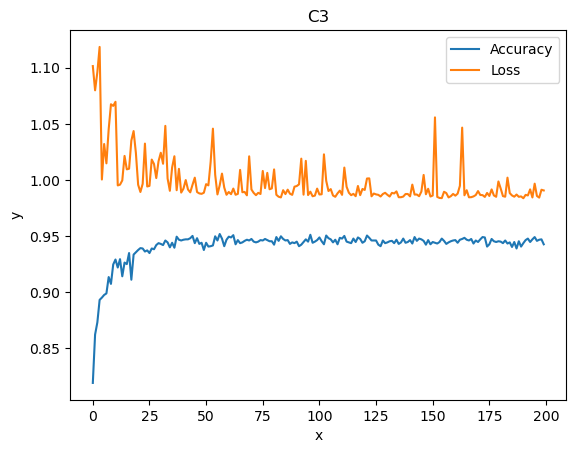

[MAdd]: Conv1d is not supported!
[Flops]: Conv1d is not supported!
[Memory]: Conv1d is not supported!
[MAdd]: Conv1d is not supported!
[Flops]: Conv1d is not supported!
[Memory]: Conv1d is not supported!
[MAdd]: Conv1d is not supported!
[Flops]: Conv1d is not supported!
[Memory]: Conv1d is not supported!
[MAdd]: Conv1d is not supported!
[Flops]: Conv1d is not supported!
[Memory]: Conv1d is not supported!
[MAdd]: BatchNorm1d is not supported!
[Flops]: BatchNorm1d is not supported!
[Memory]: BatchNorm1d is not supported!
         module name  input shape output shape    params memory(MB)          MAdd         Flops  MemRead(B)  MemWrite(B) duration[%]  MemR+W(B)
0           layer1.0    1 128   9   64  42  11     448.0       0.11     354,816.0     206,976.0      6400.0     118272.0      27.60%   124672.0
1           layer1.1   64  42  11   64  42  11     128.0       0.11     118,272.0      59,136.0    118784.0     118272.0       1.37%   237056.0
2           layer1.2   64  42  11   64  42 

/opt/conda/lib/python3.10/site-packages/torchstat/reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


In [6]:
torch.cuda.set_device(0)

train_x = np.load('/kaggle/working/HAR-datasets/UCI_HAR/x_train.npy')
train_y = np.load('/kaggle/working/HAR-datasets/UCI_HAR/y_train.npy')
test_x = np.load('/kaggle/working/HAR-datasets/UCI_HAR/x_test.npy')
test_y = np.load('/kaggle/working/HAR-datasets/UCI_HAR/y_test.npy')

print("\nShape of train_x:",train_x.shape,
      "\nShape of train_y:",train_y.shape,
      "\nShape of test_x:",test_x.shape,
      "\nShape of test_y:",test_y.shape,)

train_x = np.reshape(train_x, [-1, 1, 128, 9])
test_x = np.reshape(test_x, [-1, 1, 128, 9])
train_x = torch.from_numpy(train_x)
train_y = torch.from_numpy(train_y)
test_x = torch.from_numpy(test_x)
test_y = torch.from_numpy(test_y)
print("\nShape of train_x:",train_x.shape,
      "\nShape of train_y:",train_y.shape,
      "\nShape of test_x:",test_x.shape,
      "\nShape of test_y:",test_y.shape,)

batchSize = 32
torch_dataset = Data.TensorDataset(train_x,train_y)
train_loader = Data.DataLoader(dataset=torch_dataset,batch_size=batchSize,shuffle=True,num_workers=0)

class Net_SC(nn.Module):
    def __init__(self):
        super(Net_SC, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(6, 1), stride=(3, 1), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(6, 1), stride=(3, 1), padding=1,),
            nn.BatchNorm2d(128),
            nn.ReLU(True)
            )
        self.C2 = nn.Sequential(
            _CrossNeuronBlock(128, 13, 13, spatial_height=8, spatial_width=8, reduction=32),
            nn.BatchNorm2d(128),
            nn.ReLU(True)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(6, 1), stride=(3, 1), padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True)
            )
        self.fc = nn.Sequential(
                nn.Linear(15360, 6)
            )
        # else:
        #     exit(1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.C2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = nn.LayerNorm(x.size())(x.cpu())
        x = x.cuda()
        x = F.normalize(x.cuda())
        return x

lr_list = []
LR = 1e-4
net = Net_SC().cuda()
opt = Adam(net.parameters(),lr=LR,weight_decay=1e-5)
loss_func = nn.CrossEntropyLoss().cuda()
params = list(net.parameters())
scheduler = lr_scheduler.ExponentialLR(opt, gamma=0.97)
k = 0
layer = 0
for i in params:
    layer += 1
    print("============= 第 {} 层=============".format(layer))
    l = 1
    print("该层的结构：" + str(list(i.size())))
    for j in i.size():
        l *= j
    print("该层参数和：" + str(l))
    k = k + l
print("总参数数量和：" + str(k))
epoch_list = []
accuracy_list = []
loss_list = []
max_acc = 0
def flat(data):
    data=np.argmax(data,axis=1)
    return  data
for epoch in range(200):
    net.train()
    for step,(x,y) in enumerate(train_loader):
        x = x.type(torch.FloatTensor)
        x,y=x.cuda(),y
        output = net(x)
#         print(y.shape)
        y = y.cuda()
        loss = loss_func(output,y.long())

        net.zero_grad()
        opt.zero_grad()
        loss.backward()
        opt.step()

    if epoch%1==0:
        net.eval()
        test_x = test_x.type(torch.FloatTensor)
        test_out = net(test_x.cuda())
        pred_y = torch.max(test_out,1)[1].data.squeeze().cuda()
        lr_list.append(opt.state_dict()['param_groups'][0]['lr'])
        accuracy = (torch.sum(pred_y == test_y.float().cuda()).type(torch.FloatTensor) / test_y.size(0)).cuda()
        print('Epoch: ', epoch,  '| test accuracy: %.6f' % accuracy,'|loss:%.6f'%loss,'| params:',str(k))
        if max_acc < accuracy:
            max_acc = accuracy
        
    epoch_list.append(epoch)
    accuracy_list.append(accuracy.item())
    loss_list.append(loss.item())
    print("=====max accuracy=====")
    print(max_acc)
# print('Epoch_list:',epoch_list,'Accuracy_list:',accuracy_list,'Loss_list:',loss_list)

# cm = sm.confusion_matrix(pred_y.cpu().numpy(), flat(test_y.float()).cpu().numpy())
# print(cm)
# np.save('Store/UCI_R/confusion_matrix_b.npy',cm)
# np.save('Store/UCI/epoch_c3.npy',epoch_list)

# np.save('Store/UCI/accuracy_c3_a.npy',accuracy_list)

# np.save('Store/UCI/loss_c3.npy',loss_list)
# para = list(net.named_parameters())
# print(para)

# x = epoch_list
# y1 = accuracy_list
# y2 = loss_list
plt.plot(epoch_list,accuracy_list,label = 'Accuracy')
plt.plot(epoch_list,loss_list,label = 'Loss')
plt.title('C3')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

model = Net_SC()
stat(model, (1, 128, 9))